In [56]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras import layers
from tqdm import tqdm
import time

import glob
import imageio

from IPython import display

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
X = np.load('/content/drive/MyDrive/words_x.npy')
Y = np.load('/content/drive/MyDrive/words_y.npy')

In [59]:
# def plot_random_samples(x, y):
#   plt.figure()

#   f, axarr = plt.subplots(2, 2, figsize=(10,10)) 
#   rands = np.random.randint(x.shape[0], size=4)
#   axarr[0, 0].imshow((x[rands[0], :, :,:]))
#   axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

#   axarr[1, 0].imshow((x[rands[1], :, :,:]))
#   axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

#   axarr[0, 1].imshow((x[rands[2], :, :,:]))
#   axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

#   axarr[1, 1].imshow((x[rands[3], :, :,:]))
#   axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

#   plt.show()

In [60]:
# plot_random_samples(X, Y)

In [61]:
# plt.imshow(X[0])

In [62]:
# X.shape

#PixelCNN

In [63]:
X_train_images = X / 255.0  # Normalize the images to [0, 1]
# plot_random_samples(X_train_images, Y)

In [64]:
num_classes = 2
input_shape = (28, 28, 1)
n_residual_blocks = 5

# train = pd.read_csv('fashion-mnist_train.csv')
# data = train.drop(['label'],axis=1).to_numpy().reshape(-1,28,28,1)

X_train_images = np.where(X_train_images < (0.33 * 256), 0, 1)
X_train_images = X_train_images.astype(np.uint8)

In [65]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

In [66]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [67]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")

pixel_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 28, 28, 128)      6400      
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 28, 28, 128)      98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                     

In [68]:
pixel_cnn.fit(
    x=X_train_images, y=X_train_images, batch_size=128, epochs=50, validation_split=0.1, verbose=1
)

Epoch 1/50
111/111 [==============================] - 20s 110ms/step - loss: 0.6796 - val_loss: 0.6659
Epoch 2/50
111/111 [==============================] - 11s 103ms/step - loss: 0.6529 - val_loss: 0.6398
Epoch 3/50
111/111 [==============================] - 12s 104ms/step - loss: 0.6274 - val_loss: 0.6147
Epoch 4/50
111/111 [==============================] - 12s 104ms/step - loss: 0.6028 - val_loss: 0.5907
Epoch 5/50
111/111 [==============================] - 11s 103ms/step - loss: 0.5793 - val_loss: 0.5677
Epoch 6/50
111/111 [==============================] - 12s 105ms/step - loss: 0.5568 - val_loss: 0.5457
Epoch 7/50
111/111 [==============================] - 12s 106ms/step - loss: 0.5352 - val_loss: 0.5245
Epoch 8/50
111/111 [==============================] - 12s 107ms/step - loss: 0.5145 - val_loss: 0.5043
Epoch 9/50
111/111 [==============================] - 12s 105ms/step - loss: 0.4946 - val_loss: 0.4849
Epoch 10/50
111/111 [==============================] - 12s 106ms/step - l

In [69]:
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
          
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )

def deprocess_image(x):
    x = np.stack((x, x, x), 2)
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x

  0%|          | 0/28 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 1/28 [00:02<01:01,  2.28s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 2/28 [00:04<00:53,  2.06s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 3/28 [00:06<00:50,  2.01s/it]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 4/28 [00:08<00:48,  2.01s/it]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 5/28 [00:11<00:54,  2.38s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 6/28 [00:13<00:51,  2.35s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 7/28 [00:15<00:47,  2.24s/it]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 8/28 [00:17<00:43,  2.20s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 9/28 [00:19<00:41,  2.16s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 10/28 [00:21<00:38,  2.13s/it]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 11/28 [00:24<00:40,  2.35s/it]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 12/28 [00:26<00:37,  2.36s/it]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 13/28 [00:29<00:33,  2.26s/it]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 14/28 [00:31<00:30,  2.20s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 15/28 [00:33<00:28,  2.15s/it]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 16/28 [00:35<00:25,  2.12s/it]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 17/28 [00:38<00:25,  2.36s/it]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 18/28 [00:40<00:24,  2.42s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 19/28 [00:42<00:20,  2.32s/it]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 20/28 [00:44<00:18,  2.26s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 21/28 [00:46<00:15,  2.20s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 22/28 [00:49<00:13,  2.17s/it]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 23/28 [00:51<00:11,  2.33s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 24/28 [00:54<00:09,  2.40s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 25/28 [00:56<00:06,  2.29s/it]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 26/28 [00:58<00:04,  2.39s/it]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 27/28 [01:01<00:02,  2.36s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 28/28 [01:03<00:00,  2.26s/it]


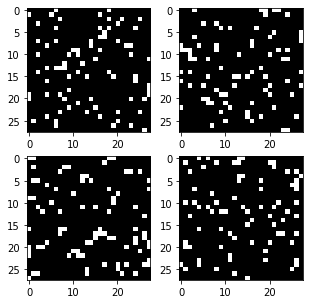

In [70]:
fig,ax = plt.subplots(2,2,figsize=(5,5))
for x in range(2):
    for y in range(2):
        ax[x,y].imshow(deprocess_image(np.squeeze(pixels[2*x+y], -1)))

## Experiment

In [49]:
# batch_size = 128
# epochs = 20
# learning_rate = 0.001
# num_classes = 2
# input_shape = (28, 28, 1)

In [50]:
# def PixelCNN(input_shape, num_classes):
#   input_layer = tf.keras.layers.Input(shape=input_shape)

#   # First layer
#   conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu')(input_layer)

#   # Residual blocks
#   for _ in range(15):
#       residual = conv1
#       conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(conv1)
#       conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu')(conv1)
#       conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same')(conv1)
#       conv1 = tf.keras.layers.Add()([residual, conv1])
#       conv1 = tf.keras.layers.Activation('relu')(conv1)

#   # Final layer
#   conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu')(conv1)
#   output_layer = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=(1, 1), padding='same', activation='softmax')(conv1)

#   # Model
#   model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#   return model

In [ ]:
# model = PixelCNN(input_shape, num_classes)
# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

In [ ]:
# model.fit(X_train_images[:100], X_train_images[:100], batch_size=batch_size, epochs=epochs)

In [13]:
# model.save('pixelcnn_model.h5')

In [14]:
# # Load model
# model = tf.keras.models.load_model('pixelcnn_model.h5')

# # Define class
# class_id = 1  # Change this to the desired class ID

# # Generate image
# generated_image = np.zeros((28, 28, 1), dtype=np.uint8)
# for i in range(28):
#     for j in range(28):
#         logits = model.predict(np.expand_dims(generated_image, axis=0))
#         probs = tf.nn.softmax(logits)[0, i, j, :]
#         generated_image[i, j, :] = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0]

# # Save image
# # filename = f'class_{class_id}_generated_image.png'
# # tf.keras.preprocessing.image.save_img(filename, generated_image)

# plt.imshow(generated_image)

## GANs

In [15]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [18]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

### Discriminator

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [20]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## Loss and Optimizers


In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [25]:
checkpoint_dir = '/content/drive/MyDrive/gan_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [26]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss)

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    loss0 = 0.
    loss1 = 0.

    for image_batch in dataset:
      losses = train_step(image_batch)
      loss0 += losses[0]
      loss1 += losses[1]

    print(loss0.numpy() / (60000//256), loss1.numpy().mean() / (60000//256))
    
    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [33]:
images_dir = '/content/drive/MyDrive/'

In [30]:
def generate_and_save_images(model, epoch, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(os.path.join(images_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

0.2735147068643162 0.22860763419387686


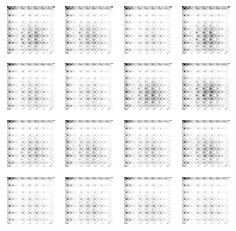

Time for epoch 1 is 3.8607289791107178 sec
0.1721991188505776 0.4216662349863949


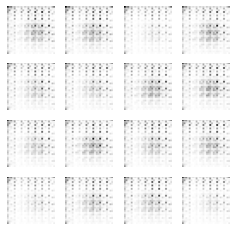

Time for epoch 2 is 3.8350770473480225 sec
0.19638055002587473 0.3708232977451422


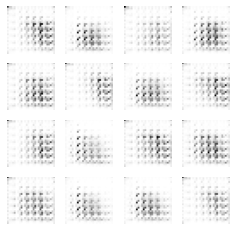

Time for epoch 3 is 3.6434738636016846 sec
0.17355276580549714 0.39560738587990785


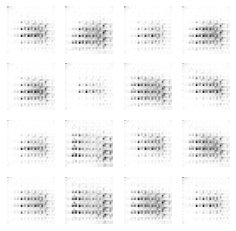

Time for epoch 4 is 4.080566883087158 sec
0.1813450185661642 0.3905200795230702


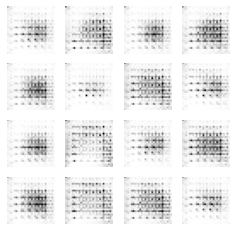

Time for epoch 5 is 3.691295623779297 sec
0.19621749617095685 0.36743121676974827


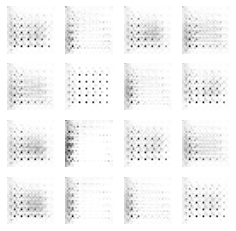

Time for epoch 6 is 3.9186878204345703 sec
0.19033524928948817 0.36294920831663996


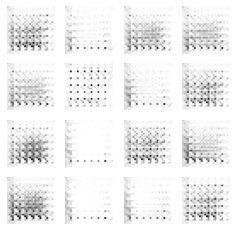

Time for epoch 7 is 3.726811408996582 sec
0.19474464807754907 0.3711022271050347


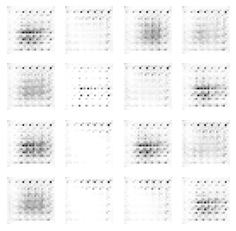

Time for epoch 8 is 5.877722978591919 sec
0.18929098406408587 0.3782981155265091


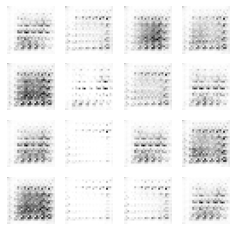

Time for epoch 9 is 4.028872966766357 sec
0.18730272798456699 0.3772926330566406


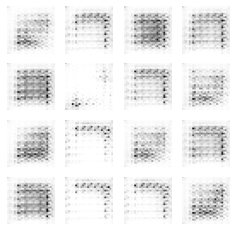

Time for epoch 10 is 4.2163002490997314 sec
0.19281476990789428 0.36482584374582666


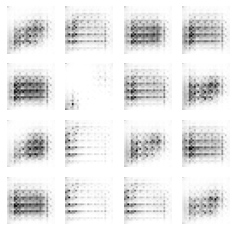

Time for epoch 11 is 4.229254484176636 sec
0.1843875982822516 0.37292265280699116


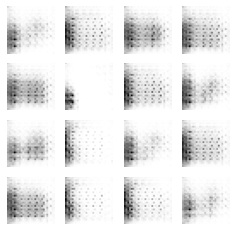

Time for epoch 12 is 3.761183261871338 sec
0.1935909955929487 0.36424007578792733


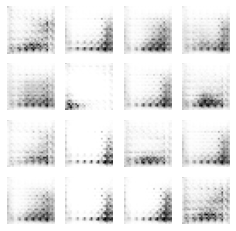

Time for epoch 13 is 4.045239210128784 sec
0.1859068096193493 0.36900652371920073


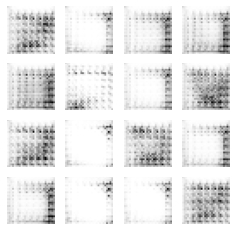

Time for epoch 14 is 4.230180263519287 sec
0.18594383174537593 0.36856023674337274


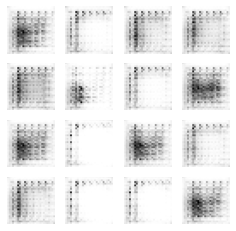

Time for epoch 15 is 4.135724067687988 sec
0.1766029749161158 0.37867674868330997


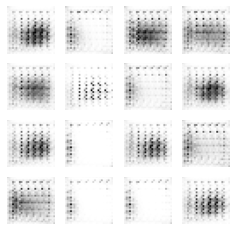

Time for epoch 16 is 4.1049299240112305 sec
0.18677701705541366 0.3677127218654013


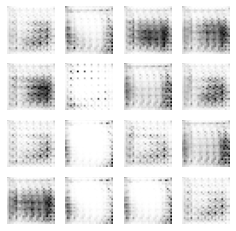

Time for epoch 17 is 4.146435260772705 sec
0.1874278304923294 0.36719343397352433


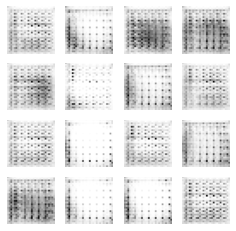

Time for epoch 18 is 3.9103291034698486 sec
0.18247045207227397 0.3682052416679187


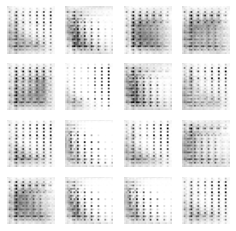

Time for epoch 19 is 3.9304006099700928 sec
0.2044643825954861 0.34451029850886417


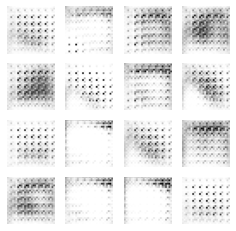

Time for epoch 20 is 4.165655851364136 sec
0.19137930258726463 0.3621729011209602


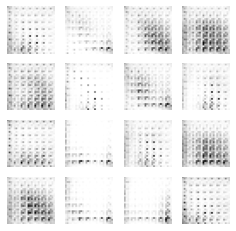

Time for epoch 21 is 4.351860523223877 sec
0.20019586677225226 0.3594495007115552


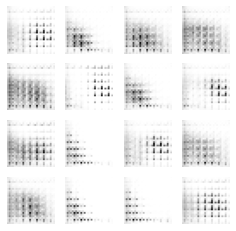

Time for epoch 22 is 3.9860732555389404 sec
0.18735370472965077 0.3567733112563435


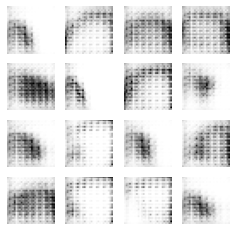

Time for epoch 23 is 4.244345426559448 sec
0.1976403130425347 0.3679274208525307


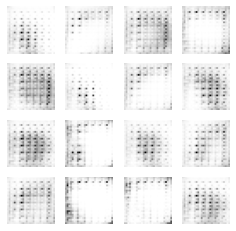

Time for epoch 24 is 4.482283115386963 sec
0.21060609409951755 0.35196956406291735


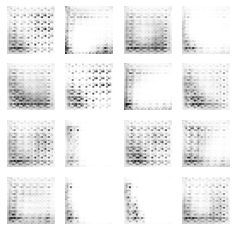

Time for epoch 25 is 4.072977542877197 sec
0.21574859945183125 0.3223904992780115


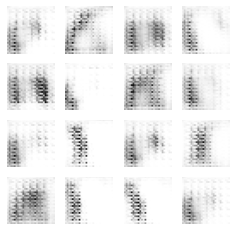

Time for epoch 26 is 4.063486337661743 sec
0.19492672651241988 0.3580134465144231


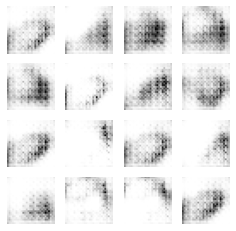

Time for epoch 27 is 4.856254816055298 sec
0.2188916980710804 0.34669527233156383


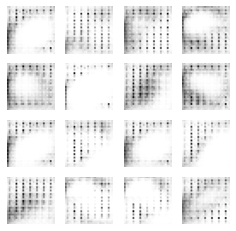

Time for epoch 28 is 4.154708385467529 sec
0.23064349247859076 0.33101422562558425


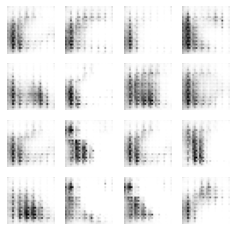

Time for epoch 29 is 4.15226936340332 sec
0.22364396315354568 0.3541186732104701


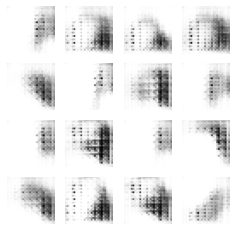

Time for epoch 30 is 5.019717693328857 sec
0.21337476551023304 0.34413290431356836


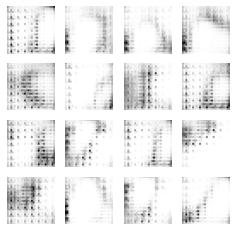

Time for epoch 31 is 4.0889177322387695 sec
0.2264949929000985 0.33205893100836337


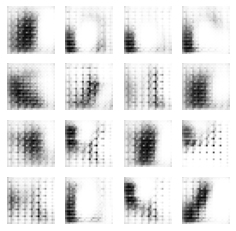

Time for epoch 32 is 4.021987676620483 sec
0.24278345678606603 0.3067397745246561


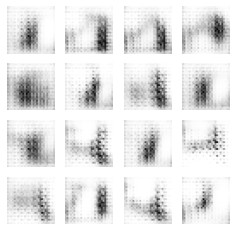

Time for epoch 33 is 4.548864841461182 sec
0.20283544165456396 0.3578562288202791


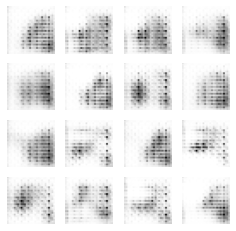

Time for epoch 34 is 4.03277587890625 sec
0.2364860110812717 0.31503230689937234


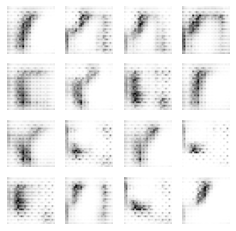

Time for epoch 35 is 3.9835970401763916 sec
0.21706556662535056 0.33964215792142427


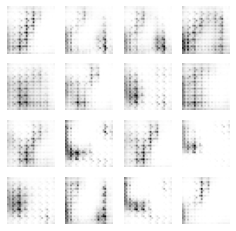

Time for epoch 36 is 3.9712305068969727 sec
0.23987313621064538 0.3191863492003873


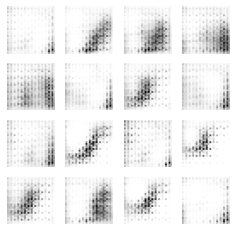

Time for epoch 37 is 4.41635537147522 sec
0.25322227804069847 0.31318358070829994


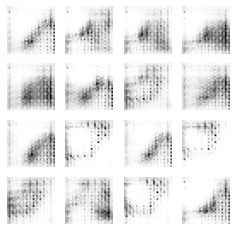

Time for epoch 38 is 3.9387547969818115 sec
0.2551823966523521 0.3053929907643897


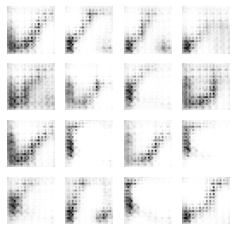

Time for epoch 39 is 3.9850966930389404 sec
0.23909223181569678 0.3208402323926616


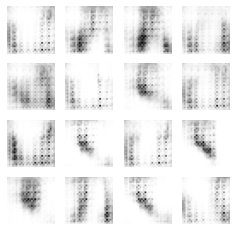

Time for epoch 40 is 4.662971496582031 sec
0.22754002432537895 0.3558743468716613


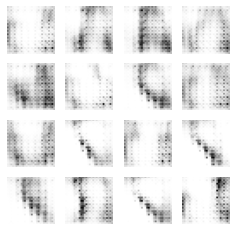

Time for epoch 41 is 3.963117837905884 sec
0.2448669661823501 0.3286225408570379


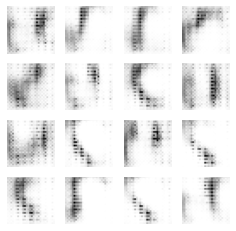

Time for epoch 42 is 3.9714508056640625 sec
0.27616497594067174 0.2993837666307759


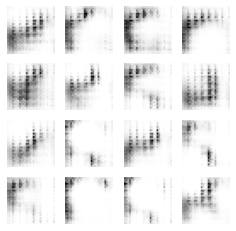

Time for epoch 43 is 4.714747667312622 sec
0.2702368711813902 0.2889063256418603


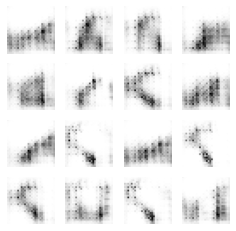

Time for epoch 44 is 4.033522605895996 sec
0.21697636139698517 0.35181593283628804


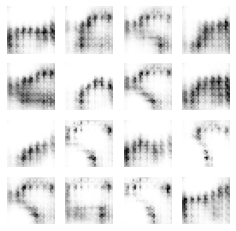

Time for epoch 45 is 4.248511075973511 sec
0.22858404501890525 0.34049964969993657


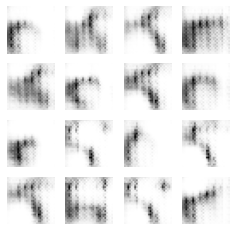

Time for epoch 46 is 4.387535810470581 sec
0.22159476973052716 0.33382604876135147


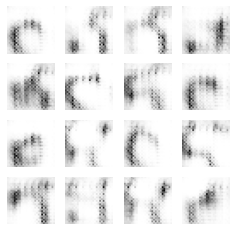

Time for epoch 47 is 4.258545398712158 sec
0.2993829189202724 0.261420160277277


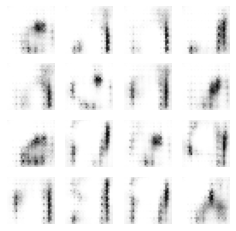

Time for epoch 48 is 4.024381637573242 sec
0.2318369873568543 0.3272054623334836


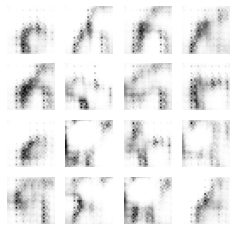

Time for epoch 49 is 4.04467248916626 sec
0.235106688279372 0.32643081795456064


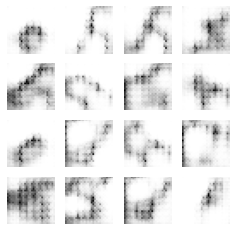

Time for epoch 50 is 4.276575565338135 sec


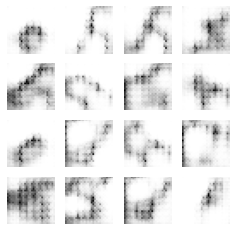

In [34]:
if tf.train.latest_checkpoint(checkpoint_dir) is None:
  train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [36]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(os.path.join(images_dir, 'image_at_epoch_{:04d}.png'.format(epoch_no)))

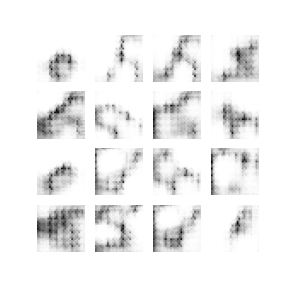

In [37]:
display_image(EPOCHS)